In [ ]:
%pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Generate the Source Data

## True Source Function

In [ ]:

train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(100) * 0.2

In [ ]:
def true_source_function(x, a, b):
    return torch.sin(x + a) + b

In [ ]:
def source_function_modifyer(x, noise, x_shift, y_shift, scale, hyperparameters):
  x_mod = x + x_shift
  y_mod = scale*true_source_function(x_mod, hyperparameters[0], hyperparameters[1])
  y_mod = y_mod + y_shift
  y_mod = y_mod + torch.randn(len(x)) * noise
  return y_mod

## Source Function 1

In [ ]:
noise_1 = 1e-2
x_shift_1 = 0.2
y_shift_1 = 0.1
scale_1 = 5
hyperparameters_1 = [np.pi/4, 2]

def source_function_1(x):
  return source_function_modifyer(x, noise_1, x_shift_1, y_shift_1, scale_1, hyperparameters_1)




## Source Function 2

In [ ]:
noise_1 = 1e-2
x_shift_1 = 0.2
y_shift_1 = 0.1
scale_1 = 5
hyperparameters_1 = [np.pi/4, 2]

def source_function_1(x):
  return source_function_modifyer(x, noise_1, x_shift_1, y_shift_1, scale_1, hyperparameters_1)

NameError: name 'np' is not defined

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

training_iter = 2

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
# Plot the data
with torch.no_grad():
    # Initialize the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get the mean and variance of the predictive distribution
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    # Plot the training data
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training data')

    # Plot the predictive mean and confidence region
    ax.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence region')

    # Set the title and legend
    ax.set_title('Gaussian Process Regression')
    ax.legend()

    # Show the plot
    plt.show()

Iter 1/50 - Loss: 0.950
Iter 2/50 - Loss: 0.919
Iter 3/50 - Loss: 0.886
Iter 4/50 - Loss: 0.848
Iter 5/50 - Loss: 0.805
Iter 6/50 - Loss: 0.756
Iter 7/50 - Loss: 0.704
Iter 8/50 - Loss: 0.651
Iter 9/50 - Loss: 0.600
Iter 10/50 - Loss: 0.554
Iter 11/50 - Loss: 0.513
Iter 12/50 - Loss: 0.476
Iter 13/50 - Loss: 0.440
Iter 14/50 - Loss: 0.406
Iter 15/50 - Loss: 0.373
Iter 16/50 - Loss: 0.340
Iter 17/50 - Loss: 0.308
Iter 18/50 - Loss: 0.276
Iter 19/50 - Loss: 0.245
Iter 20/50 - Loss: 0.215
Iter 21/50 - Loss: 0.185
Iter 22/50 - Loss: 0.157
Iter 23/50 - Loss: 0.130
Iter 24/50 - Loss: 0.104
Iter 25/50 - Loss: 0.080
Iter 26/50 - Loss: 0.059
Iter 27/50 - Loss: 0.039
Iter 28/50 - Loss: 0.023
Iter 29/50 - Loss: 0.009
Iter 30/50 - Loss: -0.001
Iter 31/50 - Loss: -0.009
Iter 32/50 - Loss: -0.013
Iter 33/50 - Loss: -0.015
Iter 34/50 - Loss: -0.014
Iter 35/50 - Loss: -0.011
Iter 36/50 - Loss: -0.008
Iter 37/50 - Loss: -0.003
Iter 38/50 - Loss: 0.001
Iter 39/50 - Loss: 0.004
Iter 40/50 - Loss: 0.007
I

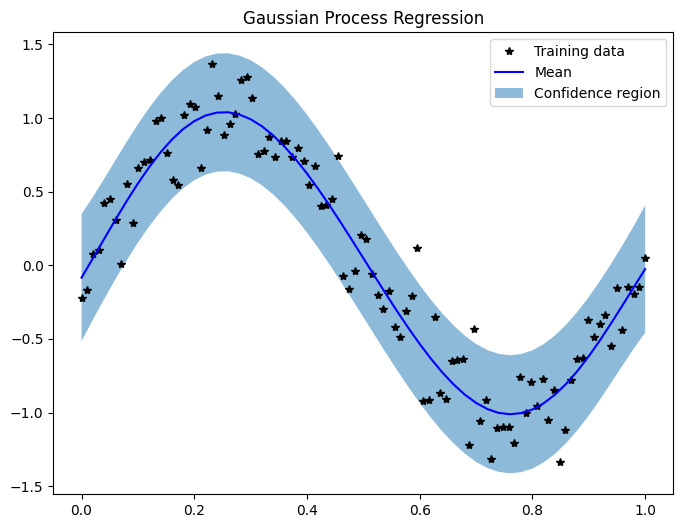

In [ ]:




# Define the Gaussian Process model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.cov_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Training
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(50):
    # Zero the gradients
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, 50, loss.item()))
    optimizer.step()

# Make predictions
model.eval()
likelihood.eval()

# Test data
test_x = torch.linspace(0, 1, 51)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plot the data
with torch.no_grad():
    # Initialize the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get the mean and variance of the predictive distribution
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    # Plot the training data
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training data')

    # Plot the predictive mean and confidence region
    ax.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence region')

    # Set the title and legend
    ax.set_title('Gaussian Process Regression')
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Training data
train_x = torch.linspace(0, 1, 100)
train_y_mean = torch.sin(train_x * (2 * np.pi))
train_y_var = torch.randn(100).abs() * 0.1 + 0.01  # Add some noise to the variance
train_y = train_y_mean + torch.randn(100) * torch.sqrt(train_y_var)

# Define the Gaussian Process model with heteroskedastic likelihood
class HeteroskedasticGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(HeteroskedasticGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.cov_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define a custom heteroskedastic likelihood
class HeteroskedasticLikelihood(gpytorch.likelihoods.Likelihood):
    def __init__(self, noise_model):
        super().__init__()
        self.noise_model = noise_model

    def _noise(self, x):
        return self.noise_model(x).exp()

    def expected_log_prob(self, target, input, *params, **kwargs):
        mean, covar = self._get_mean_and_cov(input, *params, **kwargs)
        noise = self._noise(input)
        res = ((target - mean) ** 2 + covar.diag) / noise + noise.log() + np.log(2 * np.pi)
        return res.mul(-0.5).sum(-1)

    def forward(self, input, *params, **kwargs):
        mean, covar = self._get_mean_and_cov(input, *params, **kwargs)
        noise = self._noise(input)
        return gpytorch.distributions.Normal(mean, (covar.diag + noise).sqrt())

# Initialize the noise model
class NoiseModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y_log_var, likelihood):
        super(NoiseModel, self).__init__(train_x, train_y_log_var, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.cov_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

noise_likelihood = gpytorch.likelihoods.GaussianLikelihood()
noise_model = NoiseModel(train_x, torch.log(train_y_var), noise_likelihood)

# Initialize the GP model and likelihood
likelihood = HeteroskedasticLikelihood(noise_model)
model = HeteroskedasticGPModel(train_x, train_y, likelihood)

# Training
model.train()
likelihood.train()
noise_model.train()
noise_likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': noise_model.parameters()},
    {'params': noise_likelihood.parameters()}
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(50):
    # Zero the gradients
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, 50, loss.item()))
    optimizer.step()

# Make predictions
model.eval()
likelihood.eval()
noise_model.eval()
noise_likelihood.eval()

# Test data
test_x = torch.linspace(0, 1, 51)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plot the data
with torch.no_grad():
    # Initialize the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get the mean and variance of the predictive distribution
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    # Plot the training data
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training data')
    ax.errorbar(train_x.numpy(), train_y_mean.numpy(), yerr=torch.sqrt(train_y_var).numpy(), fmt='none', ecolor='k', alpha=0.5)

    # Plot the predictive mean and confidence region
    ax.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence region')

    # Set the title and legend
    ax.set_title('Heteroskedastic Gaussian Process Regression')
    ax.legend()

    # Show the plot
    plt.show()

RuntimeError: ExactGP can only handle Gaussian likelihoods